In [86]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import json
onlyfiles = [f for f in listdir("../output") if isfile(join("../output", f))]

data_map = {}

rps_set = set()
cons_set = set()
exes_set = set()

run_files = [o for o in onlyfiles if o.endswith(".txt") and o.startswith("run")]

for output in run_files:
    with open("../output/{}".format(output), 'r') as f:
        json_str = ""
        latency_strs = []
        start_latency = False
        start_json = False
        for line in f:
            if re.search(r"^#\[Mean", line):
                start_latency = False
            if start_latency and not start_json:
                latency_strs.append(line)
            if start_json:
                json_str = "{}{}".format(json_str,line)
            if line == "JSON Output:\n":
                start_json = True
            if re.search(r"^\s+Value\s+Percentile\s+TotalCount.*", line):
                start_latency = True
        all_percentiles = [re.split(r"\s+", s.strip(" \n"))[:2] for s in latency_strs]
        run = json.loads(json_str)
        run["all_percentiles"] = [y for y in [[x for x in s if x != ''] for s in all_percentiles if len(s) > 0] if y != []]
        run_parts = output.replace(".exe", "").split(".")[0].split("-")
        exe = run_parts[1]
        rps = run_parts[2]
        cons = run_parts[3]
        rps_set.add(rps)
        cons_set.add(cons)
        exes_set.add(exe)
        if exe not in data_map:
            data_map[exe] = {}
        if cons not in data_map[exe]:
            data_map[exe][cons] = {}
        if rps not in data_map[exe][cons]:
            data_map[exe][cons][rps] = {}
        data_map[exe][cons][rps] = run

In [87]:
def extract_from_results(cons, f):
    all_lists = []
    for exe in data_map:
        l = []
        for rps in data_map[exe][str(cons)]:
            l.append([rps,f(data_map[exe][str(cons)][rps])])
        l.sort(key=lambda x: int(x[0]))
        all_lists.append(l)
    return all_lists

def latency_percentile(perct):
    def get_percentile(y):
        lat_dist = y['latency_distribution']
        percentile = next((v for v in lat_dist if v['percentile'] == perct), None)
        print(percentile)
        if percentile:
            return percentile['latency_in_microseconds']
        else:
            return None
    return get_percentile

def extract_percentiles_only(cons, rps):
    all_percentiles = []
    exes = []
    for exe in data_map:
        l = data_map[exe][str(cons)][str(rps)]["all_percentiles"]
        new_series = pd.Series([float(v[0]) for v in l], index=[str(v[1]) for v in l], name=exe)
        new_series = new_series[~new_series.index.duplicated(keep='first')]
        all_percentiles.append(new_series)
    return pd.concat(all_percentiles, axis=1)

<AxesSubplot:xlabel='load requests/second', ylabel='serviced requests/second'>

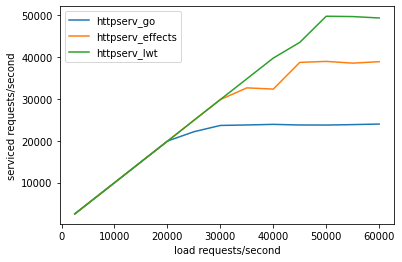

In [88]:
cons = "1000"
markers = ["o", "v", "^", "s", "D", "p", "|"]

rps_results = []

for exe in exes_set:
    r = []
    for (rps,val) in data_map[exe][cons].items():
        r.append([float(rps), val['requests_per_sec']])
    r = sorted(r, key=lambda x: x[0])
    rps_results.append(pd.Series([x[1] for x in r], index=[x[0] for x in r], dtype=np.float64, name=exe))
    
rps_df = pd.concat(rps_results, axis=1)

plot = rps_df.plot(xlabel="load requests/second", ylabel="serviced requests/second")

for (line, marker) in zip(plot.get_lines(), markers):
    line.set_marker(marker)

plot.legend(plot.get_lines(), rps_df.columns)

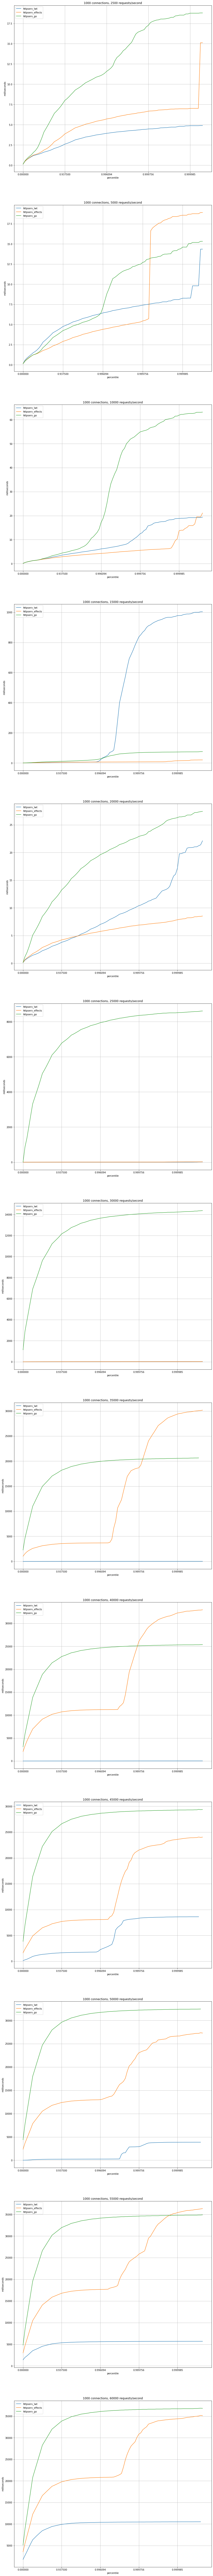

In [91]:
cons = 1000

fig, axs = plt.subplots(len(rps_set),1,figsize=(len(rps_set),200))
n = 0

for rps in sorted(rps_set, key=lambda x: float(x)):
    percentiles = extract_percentiles_only(cons, rps)
    plot = percentiles.plot(xlabel="percentile", ax=axs[n], ylabel="milliseconds", title=("{} connections, {} requests/second".format(cons, rps)), grid=True)
    for (line, marker) in zip(plot.get_lines(), markers):
        line.set_marker(marker)
    plot.legend(plot.get_lines(), percentiles.columns)
    n += 1